# Herschel Stripe 82 master catalogue
## Preparation of Spitzer SHELA data

The Spitzer/HETDEX Exploratory Large-Area (SHELA) survey covers ~24 sq. deg at 3.6 and 4.5 microns. The Spitzer/SHELA catalogues are available in `dmu0_SHELA`.

In the catalouge, we keep:

- The internal identifier;
- The position;
- The fluxes in 4 arcsecond apertures;
- The “auto” flux;


In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
33f5ec7 (Wed Dec 6 16:56:17 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, flux_to_mag

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "shela_ra"
DEC_COL = "shela_dec"

## I - Column selection

In [4]:
#IRAC1 = 3.6 um
#IRAC2 = 4.5 um
#No stelarity 

imported_columns = OrderedDict({
        'ID': "shela_intid",
        'RA': "shela_ra",
        'DEC': "shela_dec",
        'F3P6_AUTO': "f_shela_irac1",
        'F3P6ERR_AUTO': "ferr_shela_irac1",
        'F3P6_4ARCS': "f_ap_shela_irac1",
        'F3P6ERR_4ARCS': "ferr_ap_shela_irac1",
        'F4P5_AUTO': "f_shela_irac2",
        'F4P5ERR_AUTO': "ferr_shela_irac2",
        'F4P5_4ARCS': "f_ap_shela_irac2",
        'F4P5ERR_4ARCS': "ferr_ap_shela_irac2"
    })


catalogue = Table.read("../../dmu0/dmu0_SHELA/data/shela_irac_v1.3_flux_cat.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2009

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding magnitude and band-flag columns
for col in catalogue.colnames:
    if col.startswith('f_'):
        errcol = "ferr{}".format(col[1:])
        
        # Note that some fluxes are 0.
        catalogue[col][np.isclose(catalogue[col], 0.)] = np.nan
        catalogue[errcol][np.isclose(catalogue[errcol], 0.)] = np.nan
        
        magnitude, error = flux_to_mag(
            np.array(catalogue[col])/1.e6, np.array(catalogue[errcol])/1.e6)
        
        
        catalogue.add_column(Column(magnitude, name="m{}".format(col[1:])))
        catalogue.add_column(Column(error, name="m{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))


/opt/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6


In [6]:
catalogue[:10].show_in_notebook()

idx,shela_intid,shela_ra,shela_dec,f_shela_irac1,ferr_shela_irac1,f_ap_shela_irac1,ferr_ap_shela_irac1,f_shela_irac2,ferr_shela_irac2,f_ap_shela_irac2,ferr_ap_shela_irac2,m_shela_irac1,merr_shela_irac1,flag_shela_irac1,m_ap_shela_irac1,merr_ap_shela_irac1,m_shela_irac2,merr_shela_irac2,flag_shela_irac2,m_ap_shela_irac2,merr_ap_shela_irac2
0,1,15.4756838087,-1.36443322375,nan,nan,nan,nan,11.1052,0.452289,14.0416,2.15102,nan,nan,False,nan,nan,21.2862,0.0442196,False,21.0315,0.166323
1,2,15.4740823478,-1.36373876082,nan,nan,nan,nan,9.96681,0.42848,13.6084,1.69246,nan,nan,False,nan,nan,21.4036,0.0466766,False,21.0655,0.135032
2,3,15.4764671284,-1.36319564707,nan,nan,nan,nan,9.22456,0.412217,12.2394,1.66885,nan,nan,False,nan,nan,21.4876,0.0485182,False,21.1806,0.148041
3,4,14.6648752838,-1.36060981938,nan,nan,nan,nan,-0.0952322,nan,-1.22805,4.53532,nan,nan,False,nan,nan,nan,nan,False,nan,-4.00973
4,5,14.669433439,-1.36236619592,nan,nan,nan,nan,31.999,0.767752,22.2785,1.71998,nan,nan,False,nan,nan,20.1372,0.0260501,False,20.5303,0.0838229
5,6,15.4684264607,-1.36181616808,nan,nan,nan,nan,6.0504,0.333845,10.9947,1.65931,nan,nan,False,nan,nan,21.9455,0.0599081,False,21.297,0.163858
6,7,14.677735725,-1.36068860967,nan,nan,nan,nan,28.2057,0.720811,35.4973,2.39602,nan,nan,False,nan,nan,20.2742,0.0277465,False,20.0245,0.0732857
7,8,16.2727708794,-1.36338582978,nan,nan,nan,nan,24.0789,0.665996,29.4516,2.37547,nan,nan,False,nan,nan,20.4459,0.0300302,False,20.2272,0.087572
8,9,16.2775800352,-1.36178700509,nan,nan,nan,nan,29.4416,0.736433,28.0638,2.37078,nan,nan,False,nan,nan,20.2276,0.0271579,False,20.2796,0.0917209
9,10,14.6715473473,-1.36114361198,nan,nan,nan,nan,68.9906,1.12732,61.2276,1.91793,nan,nan,False,nan,nan,19.303,0.0177412,False,19.4326,0.0340102


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = ['ferr_ap_shela_irac1', 'ferr_ap_shela_irac2']
FLAG_NAME = "shela_flag_cleaned"

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 2294786 sources.
The cleaned catalogue has 2294786 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_Herschel-Stripe-82.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

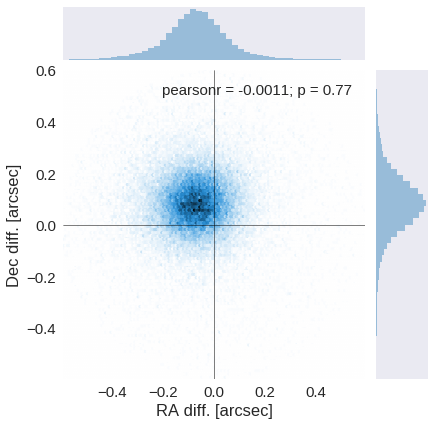

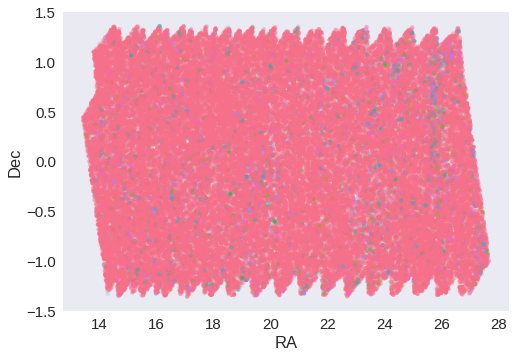

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords, near_ra0=True
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.07131256496677452 arcsec
Dec correction: -0.08313942358052495 arcsec


In [11]:
catalogue[RA_COL] = catalogue[RA_COL]  +  delta_ra.to(u.deg)
catalogue[DEC_COL] = catalogue[DEC_COL] + delta_dec.to(u.deg)

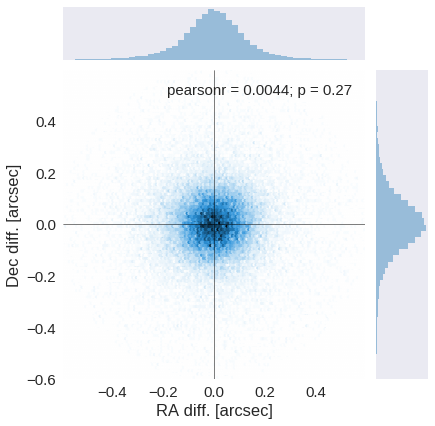

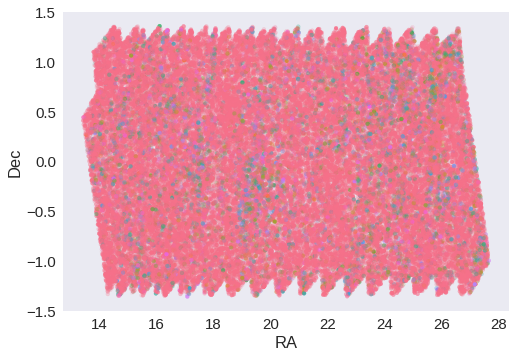

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "shela_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

68747 sources flagged.


## V - Flagging objects near bright stars

## VI - Saving to disk

In [15]:
catalogue.write("{}/SHELA.fits".format(OUT_DIR), overwrite=True)